In [1]:
## Import Packages
from __future__ import print_function

import numpy as np
import pandas as pd
from itertools import product

#Astro Software
import astropy.units as units
from astropy.coordinates import SkyCoord
from astropy.io import fits

#Plotting Packages
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams

import seaborn as sns

from PIL import Image

from yt.config import ytcfg
import yt
import yt.units as u

#Scattering NN
import torch
import torch.nn.functional as F
from torch import optim
from kymatio.torch import Scattering2D
device = "cpu"

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.decomposition import PCA, FastICA

import skimage
from skimage import filters

from scipy.optimize import curve_fit
from scipy import linalg
from scipy import stats
from scipy.signal import general_gaussian

#I/O
import h5py
import pickle
import glob
import copy
import time

#Plotting Style
%matplotlib inline
plt.style.use('dark_background')
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'

#Threading
torch.set_num_threads=2
from multiprocessing import Pool

import ntpath
def path_leaf(path):
    head, tail = ntpath.split(path)
    out = os.path.splitext(tail)[0]
    return out

def hd5_open(file_name,name):
    f=h5py.File(file_name,'r', swmr=True)
    data = f[name][:]
    f.close()
    return data

from matplotlib.colors import LinearSegmentedColormap
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
blue_red1 = LinearSegmentedColormap('BlueRed1', cdict1,N=5000)

/opt/miniconda3/envs/IWST/lib/python3.8/_collections_abc.py:666: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


To Do:
- learn rot angle
- linear equivariance
- explore delta
    - delta for S1 and S2 seperately
    - heatmap delta
    - make max delta table
- explore important coeff
    - j2>j1 condition
    - standard scaler
    - remove corner js to see if 4 spikes disapear
    - J dependent L
-explore different linear methods
- compute
    - cifar 10/100 test
    - WSTkymatio on MNIST


xx generalization gap with noisy labels

xx training size dependence 

In [2]:
def LDA_AKS_testman(X_train,y_train,X_test,y_test,n_components,label_list):
    lda = LDA(n_components=n_components)
    X_train = lda.fit_transform(X_train, y_train)
    y_pred = lda.predict(X_test)
    X_test = lda.transform(X_test)
    cm = confusion_matrix(y_test, y_pred)
    prec = precision_score(y_test, y_pred,average='micro')
    print('Accuracy' + str(prec))
    cmap_normal = (cm.T/cm.sum(axis=1)).T
    
    ## Good plots
    vmin=y_train.min()
    vmax=y_train.max()
    marker_size = 10

    from matplotlib import cm as cmplt
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    rgba_colors = [cmplt.hsv(norm(indx)) for indx, i in enumerate(label_list)]
    color_order = ["black", "white"]
    color_map = "gray"
    colormap='hsv'
    
    fig = plt.figure(figsize=(12,12),dpi=150)

    ax = fig.add_subplot(2,2,1)    
    ax.imshow(cmap_normal,
          interpolation='nearest',
          cmap=color_map,
          aspect='equal',
          vmin=0,vmax=1)

    ax.set_xticks(np.arange(cm.shape[0]))
    ax.set_yticks(np.arange(cm.shape[1]))
    
    for ytick, color in zip(ax.get_yticklabels(), rgba_colors):
        ytick.set_color(color)

    ax.set_xticklabels(label_list)
    ax.set_yticklabels(label_list)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",va='center',
             rotation_mode="anchor")
    plt.title('Test-Train Fidelity ({:.2f}%)'.format(100*prec))

    # Loop over data dimensions and create text annotations.
    textcolors=color_order
    threshold = 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] != 0:
                text = ax.text(j, i, cm[i, j],
                               ha="center", va="center", 
                               color=textcolors[int(cmap_normal[i, j] < threshold)])
    if n_components == 1:
        ax = fig.add_subplot(2,2,2)
        #ax.scatter(X_train, y_train, s=2, marker='o', zorder=10,c=y_train, cmap = 'bwr',alpha=0.5)
        #ax.scatter(X_test, y_test, s=2, marker='^', zorder=10,c=y_test, cmap = 'bwr',alpha=0.5)
        sns.distplot(X_test[y_test==0],ax=ax)
        sns.distplot(X_test[y_test==1],ax=ax)
        plt.xlabel('$LDA_{}$'.format(0))
        plt.ylabel('Probability Density')
        plt.title('LDA Projection')
        
    if n_components == 2:
        ax = fig.add_subplot(2,2,2)
        #ax.scatter(X_train[:,0], X_train[:,1], s=2, marker='o', zorder=10,c=y_train, cmap = 'bwr',alpha=0.5)
        ax.scatter(X_test[:,0], X_test[:,1], s=2, marker='^', zorder=10,c=y_test, cmap = colormap, vmin=vmin, vmax=vmax,alpha=0.5)
        plt.xlabel('$LDA_{}$'.format(i-2))
        plt.ylabel('$LDA_{}$'.format(i-1))
        plt.title('LDA Projection')
    elif n_components > 2:
        for i in range(2,5):
            ax = fig.add_subplot(2,2,i)
            #ax.scatter(X_train[:,i-2], X_train[:,i-1], s=2, marker='o', zorder=10,c=y_train, cmap = 'bwr',alpha=0.5)
            ax.scatter(X_test[:,i-2], X_test[:,i-1], s=2, marker='^', zorder=10,c=y_test, cmap = colormap, vmin=vmin, vmax=vmax,alpha=0.5)
            plt.xlabel('$LDA_{}$'.format(i-2))
            plt.ylabel('$LDA_{}$'.format(i-1))
            plt.title('LDA Projection')

    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()
    
    return (lda,cm,X_train,X_test,y_train,y_test,y_pred)

In [3]:
mnist_train_y = hd5_open('../scratch_AKS/mnist_train_y.h5','main/data')
mnist_test_y = hd5_open('../scratch_AKS/mnist_test_y.h5','main/data')

In [6]:
def DHC_iso_vec(wst,J,L):
    (nk, Nd) = np.shape(wst)
    S0 = wst[:,0:2]
    S1 = wst[:,2:J*L+2]
    S2 = np.reshape(wst[:,J*L+3:],(nk,(J*L+1),(J*L+1)))
    
    S1iso = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            S1iso[:,j1] += S1[:,l1*J+j1]
    
    S2iso = np.zeros((nk,J,J,L))
    for j1 in range(J):
        for j2 in range(J):
            for l1 in range(L):
                for l2 in range(L):
                    deltaL = np.mod(l1-l2,L)
                    S2iso[:,j1,j2,deltaL] += S2[:,l1*J+j1,l2*J+j2]
                    
    Sphi1 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi1[:,j1] += S2[:,l1*J+j1,L*J]
            
    Sphi2 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi2[:,j1] += S2[:,L*J,l1*J+j1]
            
    return np.hstack((S0,S1iso,wst[:,J*L+2].reshape(nk,1),S2iso.reshape(nk,J*J*L),Sphi1,Sphi2,S2[:,L*J,L*J].reshape(nk,1)))

In [15]:
mnist_DHC_out_sizetrain = hd5_open('../scratch_AKS/mnist_DHC_out_rot7pi_8.h5','main/data')
mnist_DHC_out_sizetest = hd5_open('../scratch_AKS/mnist_DHC_out_rot7pi_8_test.h5','main/data')
mnist_DHC_out_sizetest_iso = DHC_iso_vec(mnist_DHC_out_sizetest,6,8)
mnist_DHC_out_sizetrain_iso = DHC_iso_vec(mnist_DHC_out_sizetrain,6,8)

In [18]:
def prec_LDA(X_train,y_train,X_test,y_test,N = 10):
    lda = LDA(n_components=N-1)
    lda.fit(X_train, y_train)
    y_pred_test = lda.predict(X_test)
    y_pred_train = lda.predict(X_train)
    prec_test = precision_score(y_test, y_pred_test,average='micro')
    prec_train = precision_score(y_train, y_pred_train,average='micro')
    return prec_test,prec_train

In [19]:
prec_LDA(mnist_DHC_out_sizetrain_iso,mnist_train_y,mnist_DHC_out_sizetest_iso,mnist_test_y)

(0.9336, 0.9298333333333333)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    mnist_DHC_out_sizetrain_iso, 
    mnist_train_y, 
    stratify=mnist_train_y, 
    test_size=0.2, 
    random_state=10272021)

In [21]:
X_train.shape

(48000, 310)

In [36]:
np.linspace(0.01,0.99,99)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

In [40]:
prec_mnist_test = []
prec_mnist_train = []
for i in np.linspace(0.01,0.99,99):
    X_train, X_test, y_train, y_test = train_test_split(
        mnist_DHC_out_sizetrain_iso, 
        mnist_train_y, 
        stratify=mnist_train_y, 
        train_size=i, 
        random_state=10272021)

    prec_test_tmp, prec_train_tmp = prec_LDA(X_train,y_train,mnist_DHC_out_sizetest_iso,mnist_test_y)
    prec_mnist_test.append(prec_test_tmp)
    prec_mnist_train.append(prec_train_tmp)

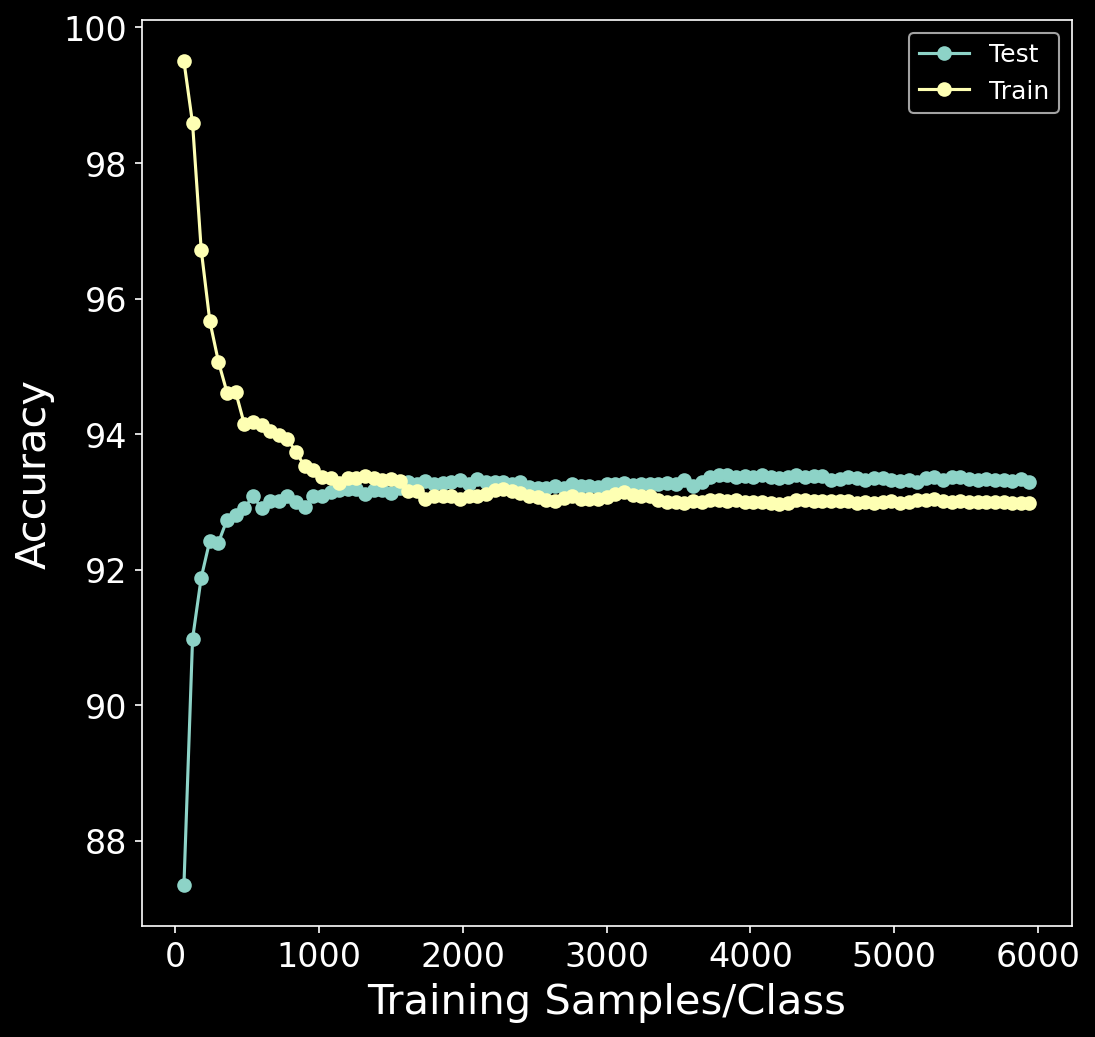

In [42]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(111) 
ax.plot(np.linspace(0.01,0.99,99)*6000,100*np.array(prec_mnist_test), 
        linestyle='-', 
        marker='o',
        label='Test')
ax.plot(np.linspace(0.01,0.99,99)*6000,100*np.array(prec_mnist_train), 
        linestyle='-', 
        marker='o',
        label='Train')
plt.xlabel('Training Samples/Class')
plt.ylabel('Accuracy')
plt.legend()

In [43]:
np.linspace(0.01,0.99,99)*6000

array([  60.,  120.,  180.,  240.,  300.,  360.,  420.,  480.,  540.,
        600.,  660.,  720.,  780.,  840.,  900.,  960., 1020., 1080.,
       1140., 1200., 1260., 1320., 1380., 1440., 1500., 1560., 1620.,
       1680., 1740., 1800., 1860., 1920., 1980., 2040., 2100., 2160.,
       2220., 2280., 2340., 2400., 2460., 2520., 2580., 2640., 2700.,
       2760., 2820., 2880., 2940., 3000., 3060., 3120., 3180., 3240.,
       3300., 3360., 3420., 3480., 3540., 3600., 3660., 3720., 3780.,
       3840., 3900., 3960., 4020., 4080., 4140., 4200., 4260., 4320.,
       4380., 4440., 4500., 4560., 4620., 4680., 4740., 4800., 4860.,
       4920., 4980., 5040., 5100., 5160., 5220., 5280., 5340., 5400.,
       5460., 5520., 5580., 5640., 5700., 5760., 5820., 5880., 5940.])

In [57]:
np.linspace(0.01,0.90,90)*6000

array([  60.,  120.,  180.,  240.,  300.,  360.,  420.,  480.,  540.,
        600.,  660.,  720.,  780.,  840.,  900.,  960., 1020., 1080.,
       1140., 1200., 1260., 1320., 1380., 1440., 1500., 1560., 1620.,
       1680., 1740., 1800., 1860., 1920., 1980., 2040., 2100., 2160.,
       2220., 2280., 2340., 2400., 2460., 2520., 2580., 2640., 2700.,
       2760., 2820., 2880., 2940., 3000., 3060., 3120., 3180., 3240.,
       3300., 3360., 3420., 3480., 3540., 3600., 3660., 3720., 3780.,
       3840., 3900., 3960., 4020., 4080., 4140., 4200., 4260., 4320.,
       4380., 4440., 4500., 4560., 4620., 4680., 4740., 4800., 4860.,
       4920., 4980., 5040., 5100., 5160., 5220., 5280., 5340., 5400.])

In [51]:
combo_mnist_iso_x = np.vstack((mnist_DHC_out_sizetrain_iso,mnist_DHC_out_sizetest_iso))
combo_mnist_iso_y = np.hstack((mnist_train_y,mnist_test_y))

In [58]:
prec_mnist_test2 = []
prec_mnist_train2 = []
for i in np.linspace(0.01,0.90,90):
    X_train, X_test, y_train, y_test = train_test_split(
        mnist_DHC_out_sizetrain_iso, 
        mnist_train_y, 
        stratify=mnist_train_y, 
        train_size=i,
        test_size=0.1,
        random_state=int(i*10000))

    prec_test_tmp, prec_train_tmp = prec_LDA(X_train,y_train,X_test,y_test)
    prec_mnist_test2.append(prec_test_tmp)
    prec_mnist_train2.append(prec_train_tmp)

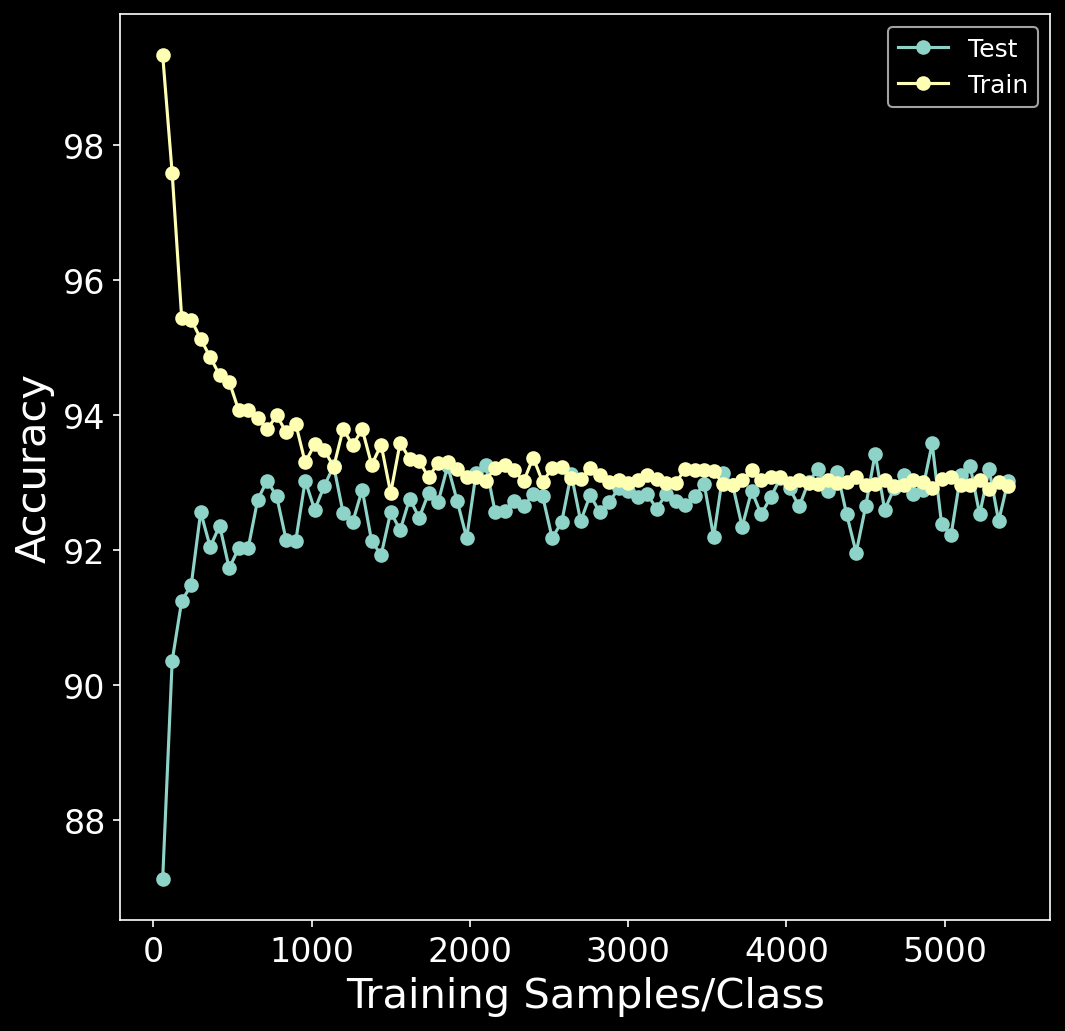

In [60]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(111) 
ax.plot(np.linspace(0.01,0.90,90)*6000,100*np.array(prec_mnist_test2), 
        linestyle='-', 
        marker='o',
        label='Test')
ax.plot(np.linspace(0.01,0.90,90)*6000,100*np.array(prec_mnist_train2), 
        linestyle='-', 
        marker='o',
        label='Train')
plt.xlabel('Training Samples/Class')
plt.ylabel('Accuracy')
plt.legend()

In [69]:
prec_mnist_test3 = []
prec_mnist_train3 = []
for i in np.linspace(0.01,0.90,90):
    X_train, X_test, y_train, y_test = train_test_split(
        combo_mnist_iso_x, 
        combo_mnist_iso_y, 
        stratify=combo_mnist_iso_y, 
        train_size=i,
        test_size=0.1,
        random_state=int(i*10000))

    prec_test_tmp, prec_train_tmp = prec_LDA(X_train,y_train,X_test,y_test)
    prec_mnist_test3.append(prec_test_tmp)
    prec_mnist_train3.append(prec_train_tmp)

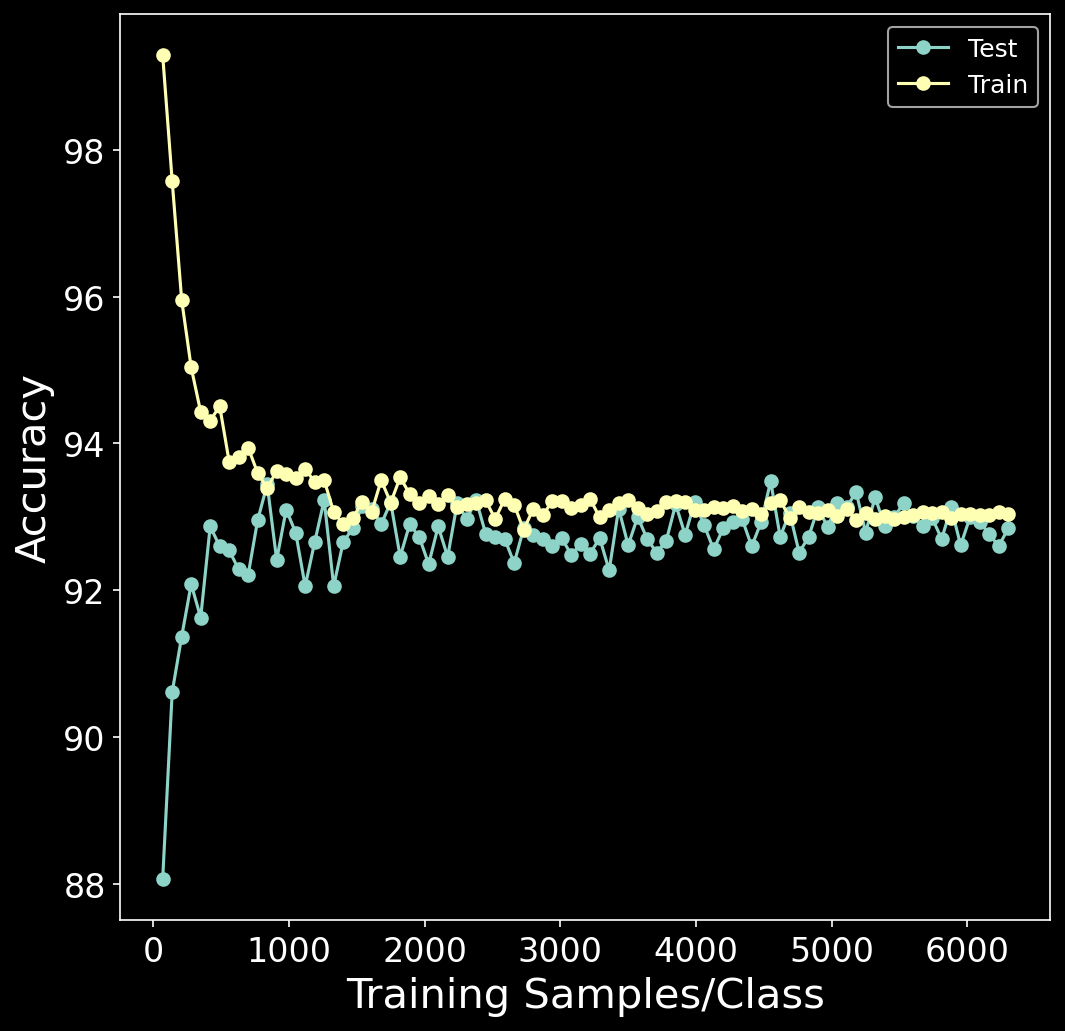

In [81]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(111) 
ax.plot(np.linspace(0.01,0.90,90)*7000,100*np.array(prec_mnist_test3), 
        linestyle='-', 
        marker='o',
        label='Test')
ax.plot(np.linspace(0.01,0.90,90)*7000,100*np.array(prec_mnist_train3), 
        linestyle='-', 
        marker='o',
        label='Train')
plt.xlabel('Training Samples/Class')
plt.ylabel('Accuracy')
plt.legend()

In [71]:
temp_y = mnist_test_y
a = [i for i in range(10000)]
indx = np.random.choice(a, size=0, replace=False)
temp_y[indx] = np.random.randint(low=0,high=10,size=0)

In [75]:
mix_vec = np.linspace(0,70000,101)

In [77]:
prec_mnist_test4= []
prec_mnist_train4 = []

a = [i for i in range(70000)]
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
rs = RandomState(MT19937(SeedSequence(123456789)))
for i in mix_vec:
    random_y = combo_mnist_iso_y
    
    indx = np.random.choice(a, size=int(i), replace=False)
    random_y[indx] = np.random.randint(low=0,high=10,size=int(i))
    
    X_train, X_test, y_train, y_test = train_test_split(
        combo_mnist_iso_x, 
        combo_mnist_iso_y, 
        stratify=combo_mnist_iso_y, 
        train_size=0.8,
        test_size=0.2,
        random_state=int(i))

    prec_test_tmp, prec_train_tmp = prec_LDA(X_train,y_train,X_test,y_test)
    prec_mnist_test4.append(prec_test_tmp)
    prec_mnist_train4.append(prec_train_tmp)

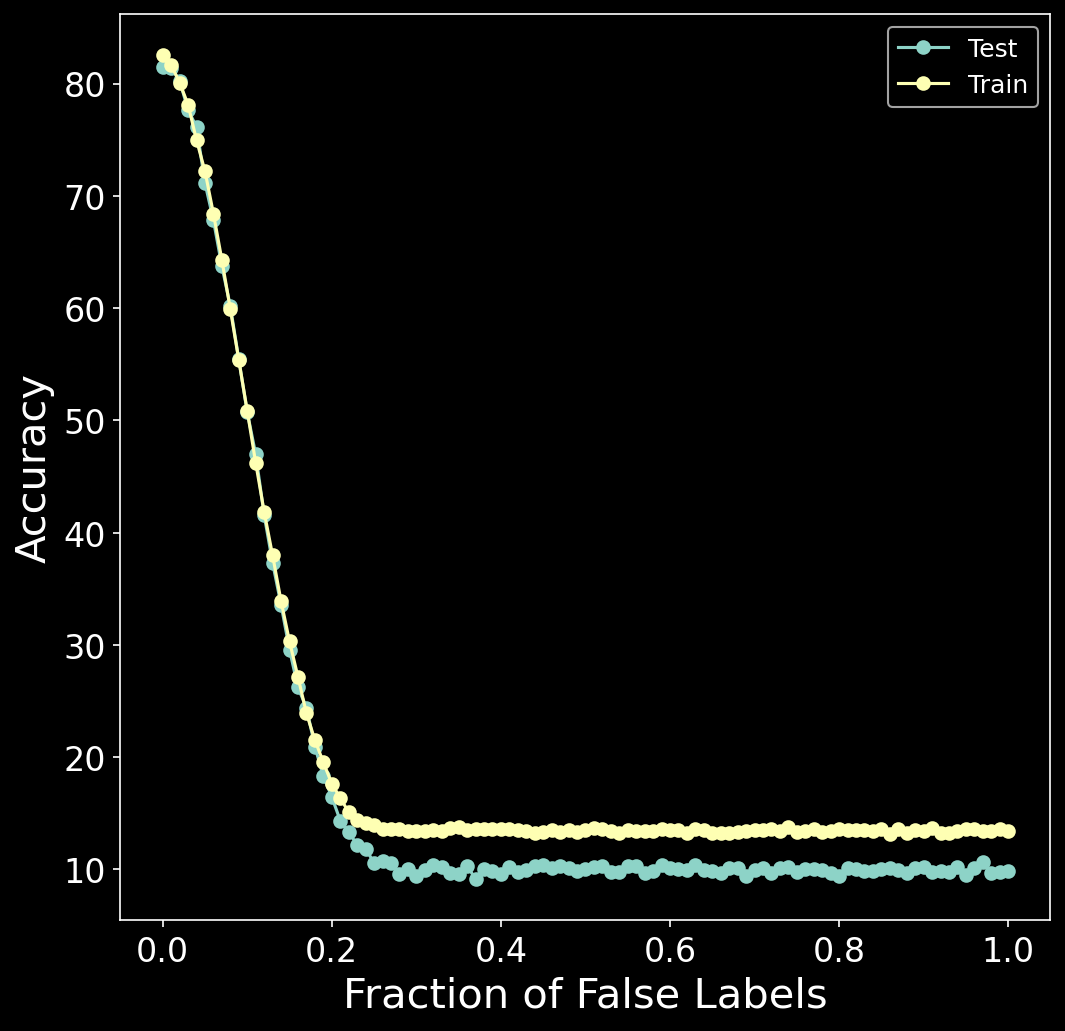

In [80]:
fig = plt.figure(figsize=(8,8),dpi=150)

fract = mix_vec/70000

ax = fig.add_subplot(111) 
ax.plot(fract,100*np.array(prec_mnist_test4), 
        linestyle='-', 
        marker='o',
        label='Test')
ax.plot(fract,100*np.array(prec_mnist_train4), 
        linestyle='-', 
        marker='o',
        label='Train')
plt.xlabel('Fraction of False Labels')
plt.ylabel('Accuracy')
plt.legend()

In [82]:
mnist_DHC_out_sizetrain = hd5_open('../from_cannon/2021_01_22/mnist_DHC_train_ang_1_2.h5','main/data')
mnist_DHC_out_sizetest = hd5_open('../from_cannon/2021_01_23/mnist_DHC_test_ang_1_2.h5','main/data')
mnist_DHC_out_size_iso = DHC_iso_vec(mnist_DHC_out_sizetest,6,8)
mnist_DHC_out_size_iso.shape, mnist_DHC_out_sizetest.shape

((1000000, 310), (1000000, 2452))

In [83]:
mnist_DHC_out_size_iso_reshape = mnist_DHC_out_size_iso.reshape(10000,100,310)
angles_std = np.std(mnist_DHC_out_size_iso_reshape,axis=1)
np.mean(angles_std)

2.0105284557001678e-05

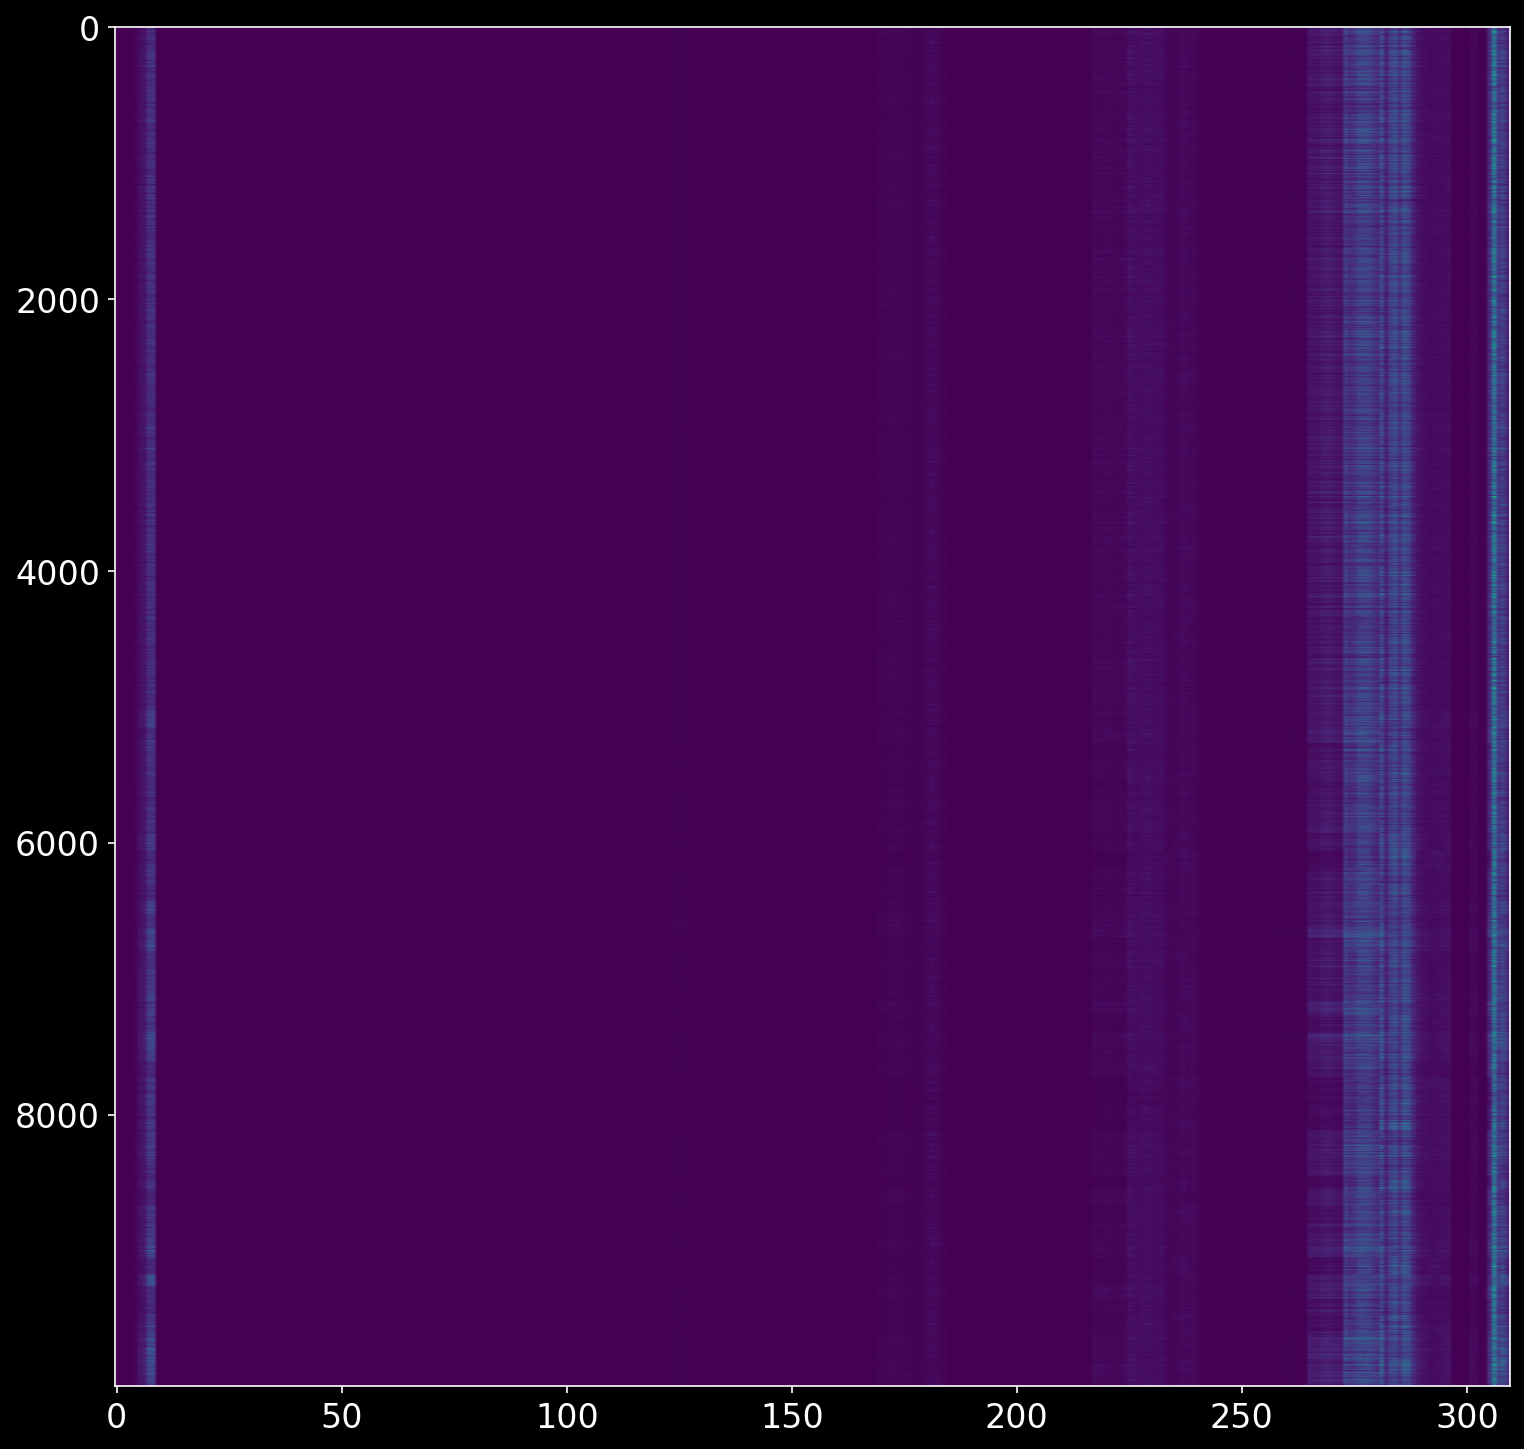

In [85]:
fig = plt.figure(figsize=(12,12),dpi=150)
ax = fig.add_subplot(1,1,1)    
ax.imshow(angles_std,
         aspect='auto')

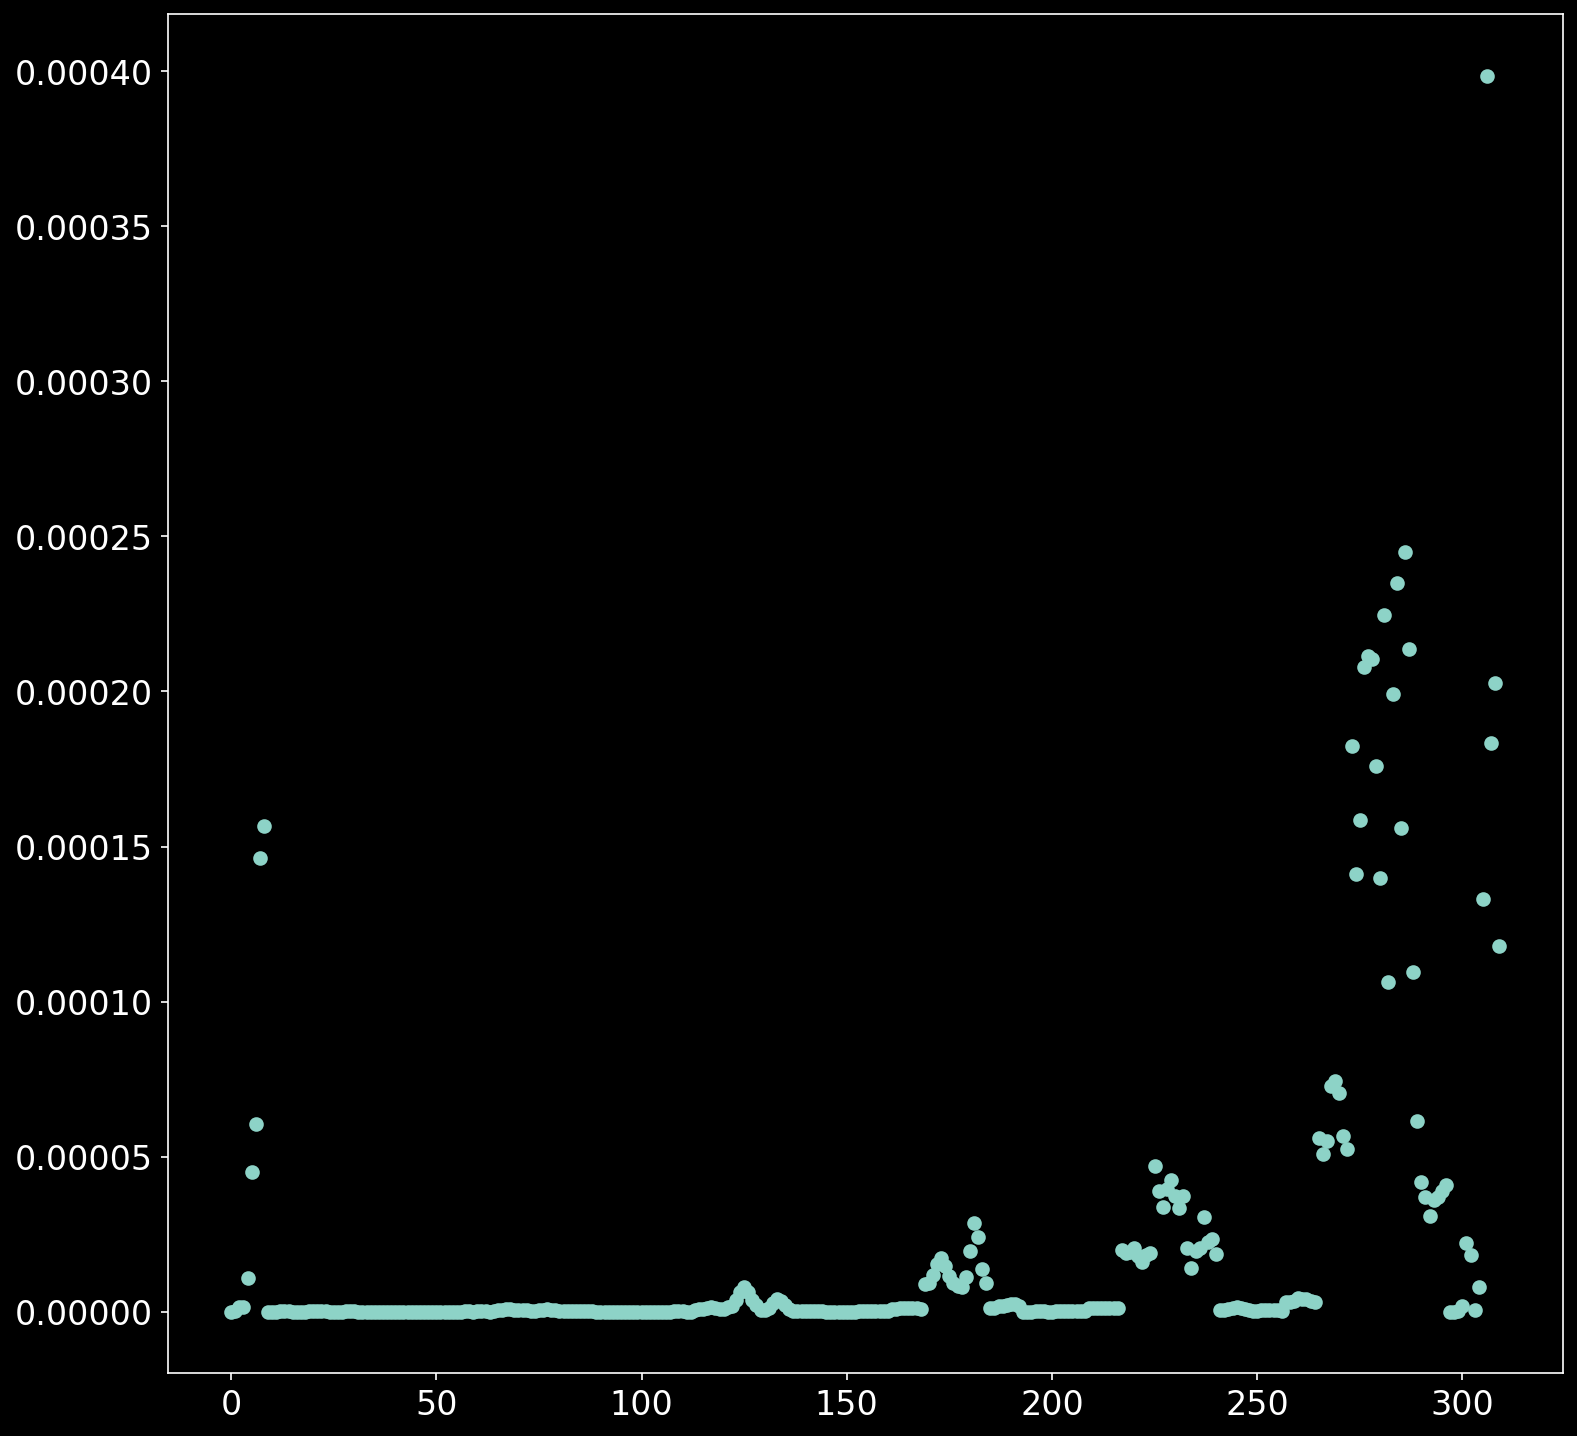

In [87]:
fig = plt.figure(figsize=(12,12),dpi=150)
ax = fig.add_subplot(1,1,1)    
ax.scatter([i for i in range(310)],np.mean(angles_std,axis=0))

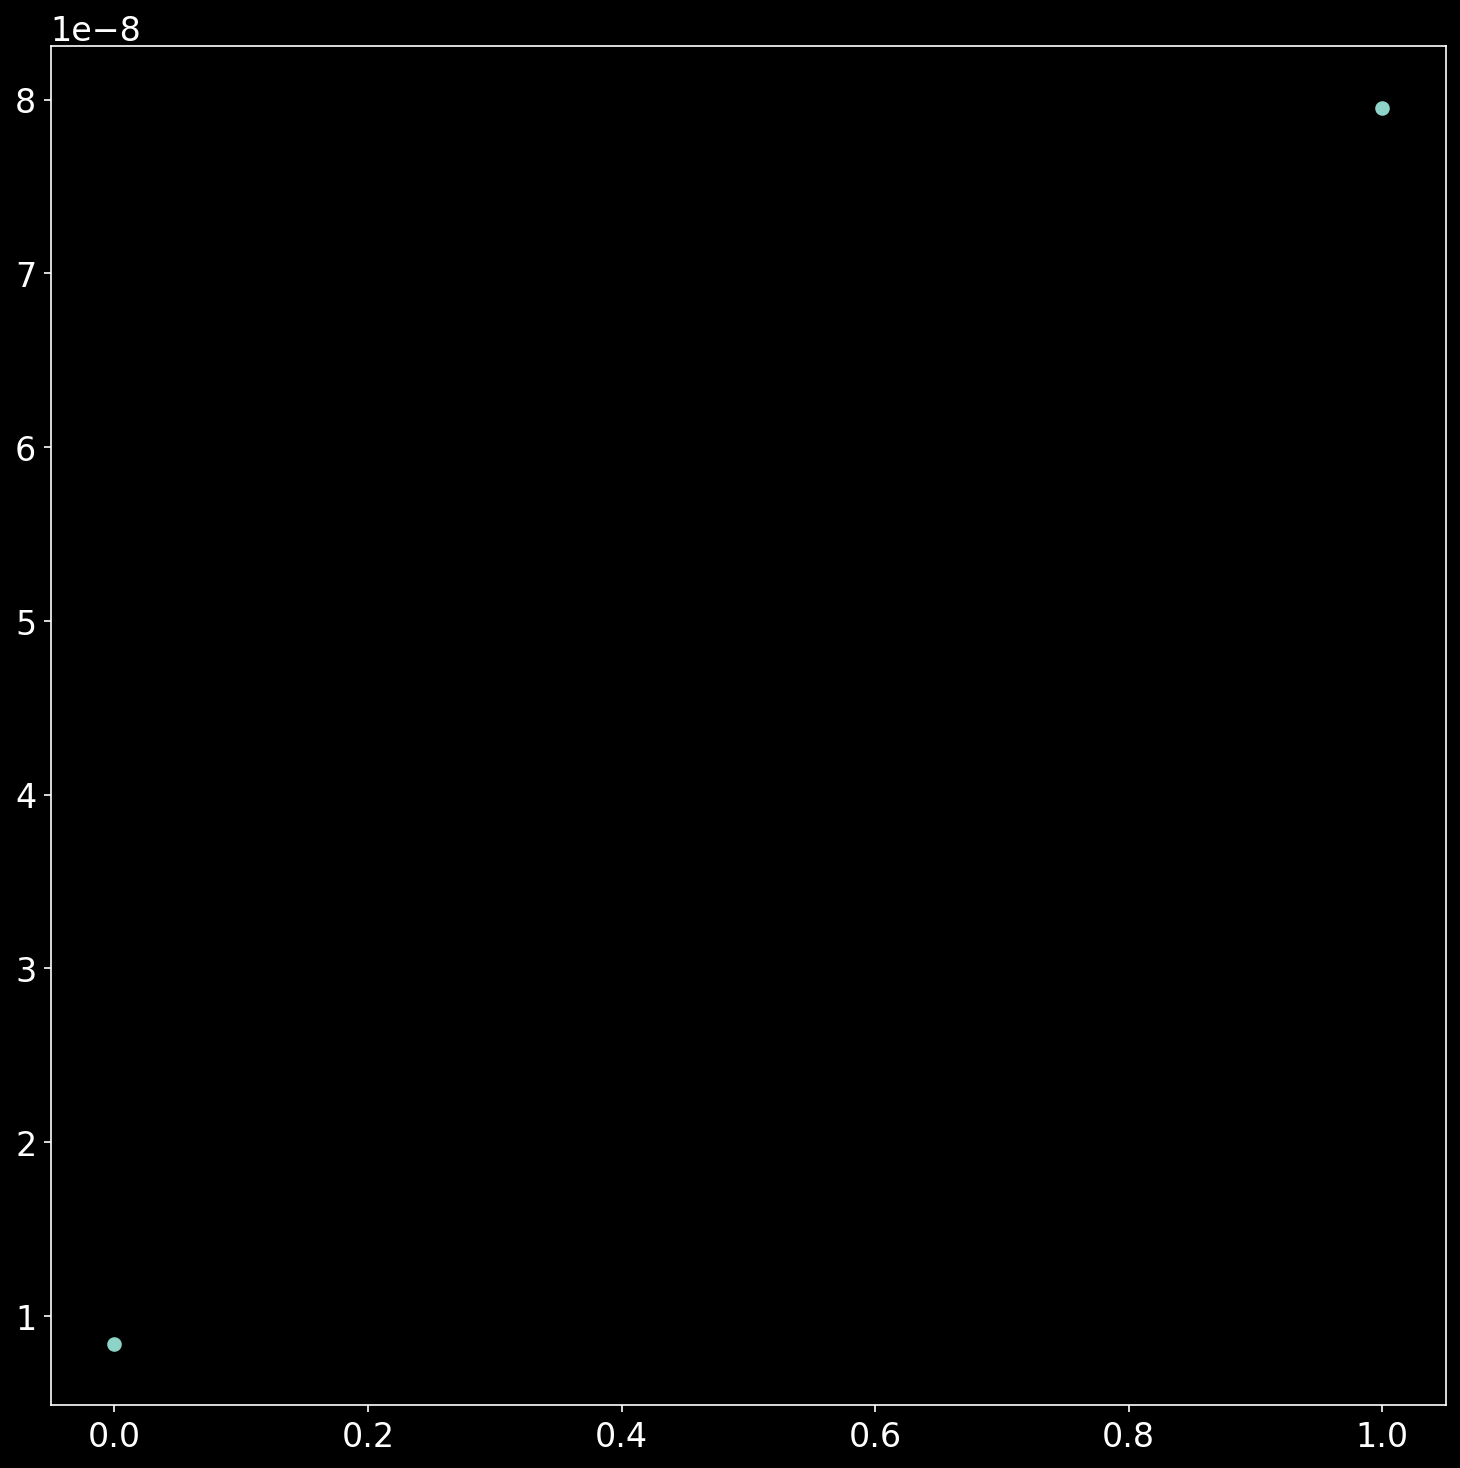

In [88]:
fig = plt.figure(figsize=(12,12),dpi=150)
ax = fig.add_subplot(1,1,1)    
ax.scatter([i for i in range(2)],np.mean(angles_std,axis=0)[:2])

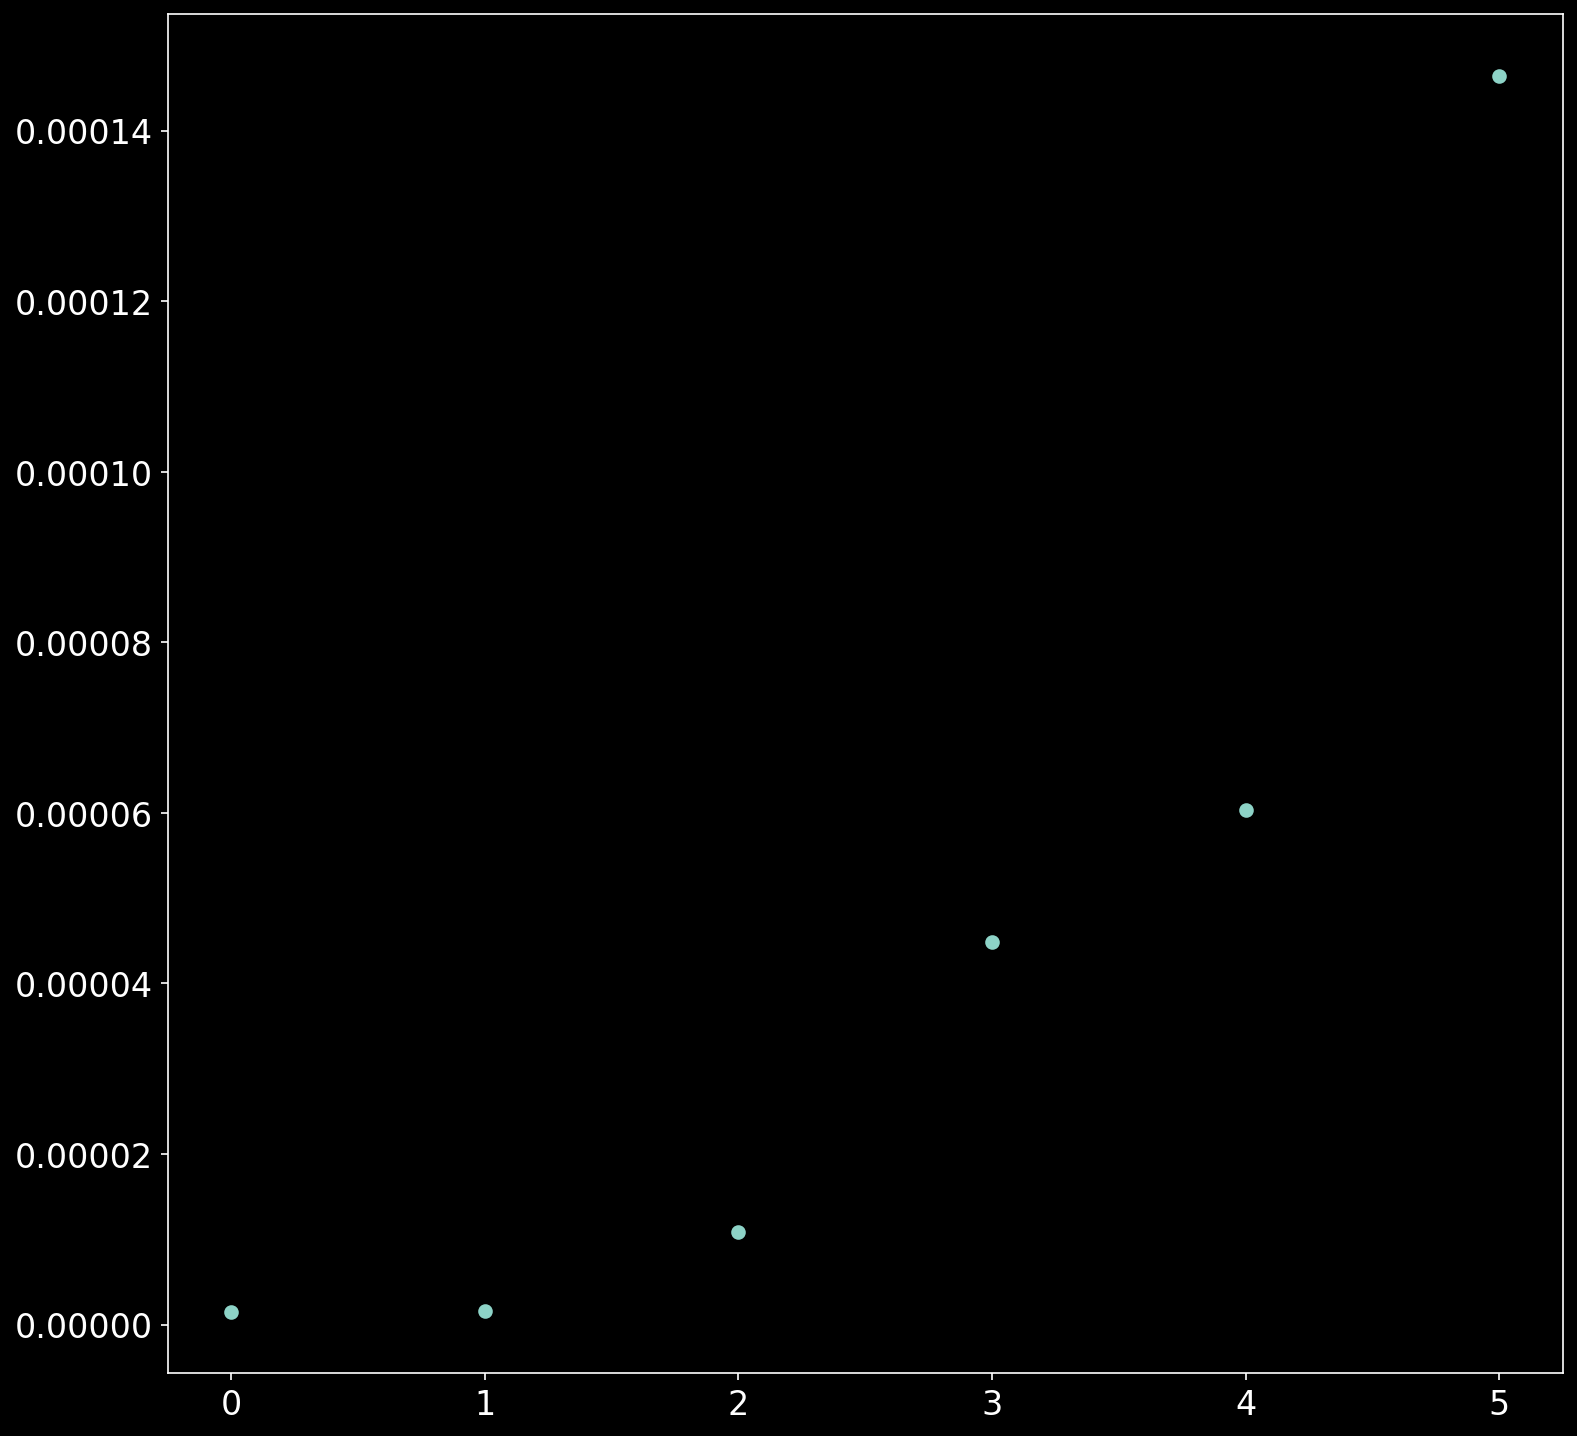

In [91]:
fig = plt.figure(figsize=(12,12),dpi=150)
ax = fig.add_subplot(1,1,1)    
ax.scatter([i for i in range(6)],np.mean(angles_std,axis=0)[2:8])